# UFO Sighthings  

Se provee una base de datos que contiene avistamientos de ovnis en años pasados. Se pide Responder algunas preguntas respecto a estos avistamientos:   
1. ¿Dónde dirías que es más probable tener avistamientos ovnis?
2. ¿Observas algún tipo de patrón en los avistamientos a lo largo del tiempo? ¿Crees que exista alguna estacionalidad en los eventos?
3. ¿Qué correlaciones encuentras con los lugares donde hubo avistamientos?
4. ¿En general, cómo se ve los ovnis que se describen en los avistamientos?



## Análisis Exploratorio de Datos

In [1]:
# Lectura del file
import pandas as pd
import csv

ufo_raw = pd.read_csv("Business case/UFO_sightings.csv",
                        sep=",",
                        quotechar='"',
                        dtype=str,
                        engine="python",
                        on_bad_lines="skip"           # Ignora filas muy corruptas, pero preserva la mayoría
    )

ufo_raw.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.9411111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.6458333
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.8036111


### Revisión de la temporalidad

In [2]:
# Limpieza de las variables
df_ufo = ufo_raw.copy() # Trabajar un df nuevo con los ajustes y preservar el original.
# Convertir columnas 'datetime' y 'date posted' al tipo datetime
df_ufo["datetime"] = pd.to_datetime(df_ufo["datetime"], errors="coerce")
df_ufo["date posted"] = pd.to_datetime(df_ufo["date posted"], errors="coerce")

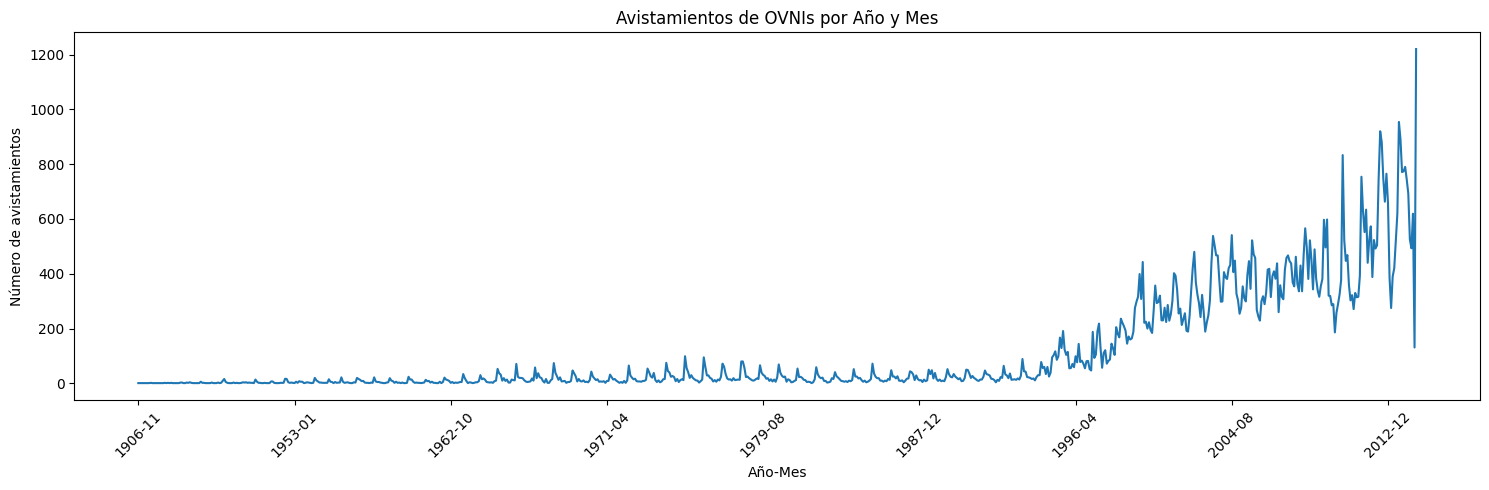

In [3]:
import matplotlib.pyplot as plt

# Crear columna con año-mes
df_ufo["year_month"] = df_ufo["datetime"].dt.to_period("M").astype(str)

# Conteo por año-mes
conteo_mensual = df_ufo["year_month"].value_counts().sort_index()

# Graficar
plt.figure(figsize=(15, 5))
conteo_mensual.plot(kind="line")
plt.xlabel("Año-Mes")
plt.ylabel("Número de avistamientos")
plt.title("Avistamientos de OVNIs por Año y Mes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

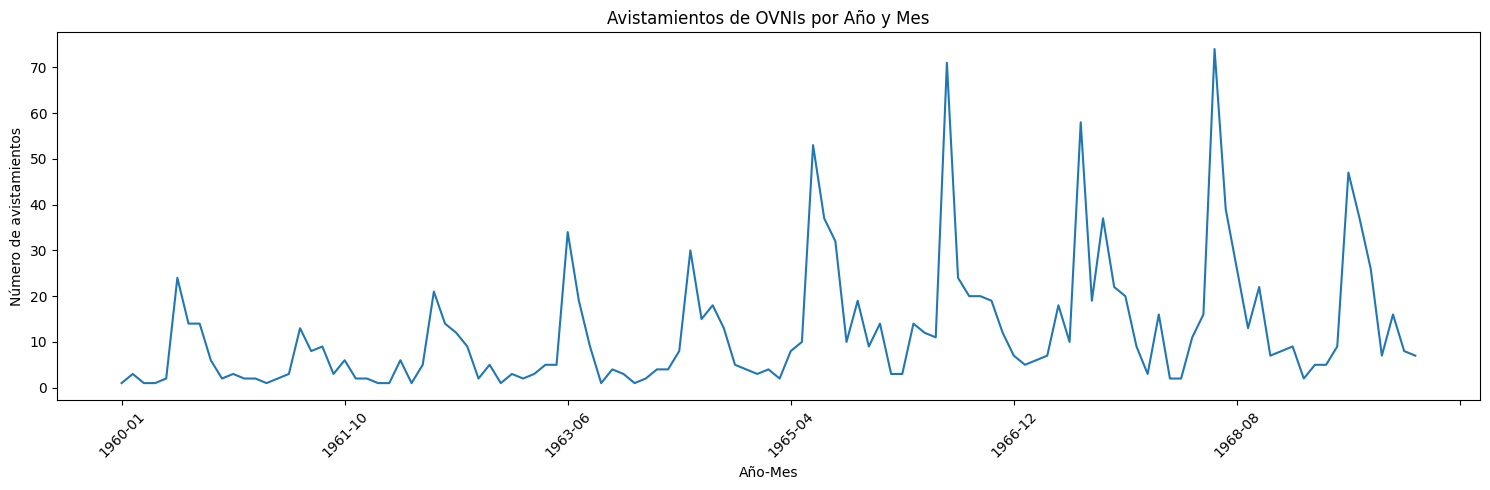

In [4]:
# Filtrar el rango entre 1900 y 1950
conteo_mensual_filtrado = conteo_mensual[
    (conteo_mensual.index >= "1960") & (conteo_mensual.index <= "1970")
]

plt.figure(figsize=(15, 5))
conteo_mensual_filtrado.plot(kind="line")
plt.xlabel("Año-Mes")
plt.ylabel("Número de avistamientos")
plt.title("Avistamientos de OVNIs por Año y Mes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

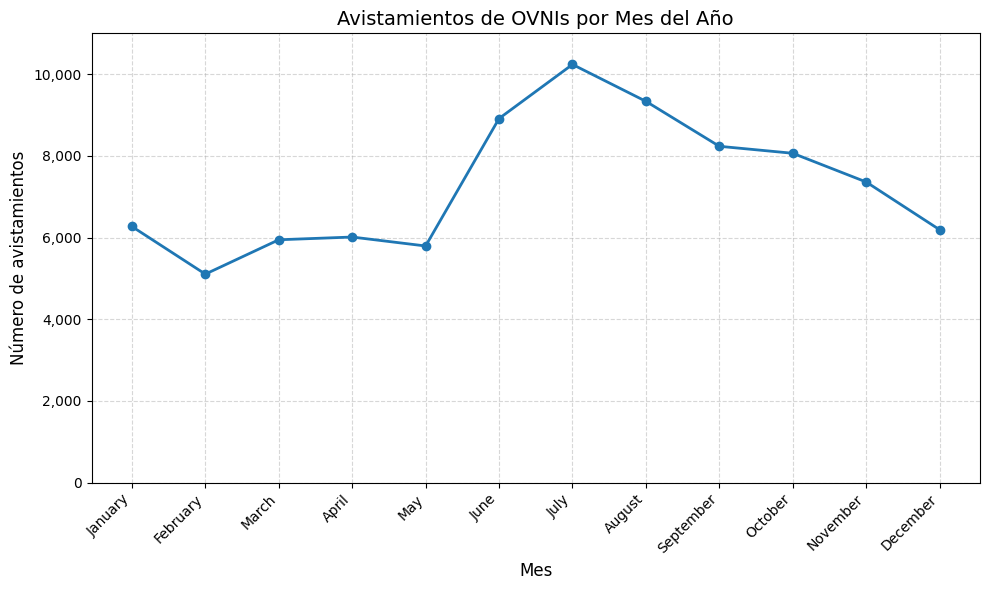

In [5]:
import calendar

# Conteo de avistamientos por mes
conteo_por_mes = df_ufo["datetime"].dt.month.value_counts().sort_index()

# Crear lista de nombres de meses según el índice
nombres_meses = [calendar.month_name[int(i)] for i in conteo_por_mes.index]

# Graficar
import matplotlib.ticker as mticker

plt.figure(figsize=(10, 6))
plt.plot(nombres_meses, conteo_por_mes.values, marker='o', linewidth=2)
plt.title("Avistamientos de OVNIs por Mes del Año", fontsize=14)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Número de avistamientos", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0,11_000)
plt.grid(True, linestyle='--', alpha=0.5)
# Formato de miles con coma en el eje Y
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.tight_layout()
plt.show()

### Revisión de la ubicación

In [6]:
df_ufo["latitude"] = pd.to_numeric(df_ufo["latitude"], errors="coerce")
df_ufo["longitude"] = pd.to_numeric(df_ufo["longitude"], errors="coerce")

In [7]:
# Cantidad de faltantes
df_ufo[["country", "state", "city", "latitude", "longitude"]].isna().sum()

country      12365
state         7409
city             0
latitude         1
longitude        0
dtype: int64

In [8]:
# Country valores
df_country_counts = df_ufo['country'].value_counts(dropna=False).reset_index()
df_country_counts['Pct'] = round(df_country_counts['count']/df_country_counts['count'].sum()*100, 2)
df_country_counts

,country,count,Pct
0,us,70293,79.27
1,NaN,12365,13.94
2,ca,3266,3.68
3,gb,2050,2.31
4,au,593,0.67
5,de,112,0.13


In [32]:
print("Cantidad de Avistamientos con un Pais declarado en el set de datos:", df_ufo['country'].value_counts().sum())

Cantidad de Avistamientos con un Pais declarado en el set de datos: 76314


In [9]:
# Donde la longitued es diferente de 0 y el country es nulo
df_ufo[(df_ufo['longitude'] != '0') & (df_ufo['country'].isnull())].shape

(12365, 12)

In [10]:
import reverse_geocoder as rg
import pycountry

# Filtrar solo filas con coordenadas válidas
mask_valid_coords = (
    df_ufo["latitude"].notna() &
    df_ufo["longitude"].notna() &
    (df_ufo["latitude"] != 0) &
    (df_ufo["longitude"] != 0)
)
coordenadas = list(zip(df_ufo.loc[mask_valid_coords, "latitude"], df_ufo.loc[mask_valid_coords, "longitude"]))

# Aplicar reverse geocoding solo a las filas válidas
resultados = rg.search(coordenadas, mode=2)

# Insertar los resultados directamente en df_ufo
df_ufo.loc[mask_valid_coords, "lat_guess"] = [r["lat"] for r in resultados]
df_ufo.loc[mask_valid_coords, "lon_guess"] = [r["lon"] for r in resultados]
df_ufo.loc[mask_valid_coords, "city_guess"] = [r["name"] for r in resultados]
df_ufo.loc[mask_valid_coords, "admin1_guess"] = [r["admin1"] for r in resultados]
df_ufo.loc[mask_valid_coords, "admin2_guess"] = [r["admin2"] for r in resultados]
df_ufo.loc[mask_valid_coords, "country_code_guess"] = [r["cc"] for r in resultados]

def iso_to_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code.upper()).name
    except:
        return None

# Crear nueva columna con nombre del país
df_ufo.loc[mask_valid_coords, "country_name_guess"] = df_ufo.loc[mask_valid_coords, "country_code_guess"].apply(iso_to_country_name)
# (Opcional) Línea para borrar columnas si ya no las necesitas:
# df_ufo.drop(columns=["lat_guess", "lon_guess", "city_guess", "admin1_guess", "admin2_guess", "country_code_guess"], inplace=True)

Loading formatted geocoded file...


In [12]:
df_ufo[df_ufo['country'] == 'us']['country_name_guess'].value_counts(dropna=False)

country_name_guess
United States         70243
Puerto Rico              26
Canada                   16
Mexico                    5
Russian Federation        3
Name: count, dtype: int64

In [20]:
ufo_country = df_ufo[['country_name_guess']].value_counts(dropna=False).reset_index()
ufo_country

,country_name_guess,count
0,United States,76742
1,Canada,3927
2,United Kingdom,2581
3,NaN,1505
4,Australia,698
...,...,...
165,"Congo, The Democratic Republic of the",1
166,Cameroon,1
167,"Saint Helena, Ascension and Tristan da Cunha",1
168,Cabo Verde,1


In [34]:
print('Cantidad de Avistamientos con un Pais asignado en el set de datos:', df_ufo['country_name_guess'].value_counts().sum())

Cantidad de Avistamientos con un Pais asignado en el set de datos: 87174


Con el objetivo de completar los valores faltantes en la variable country, se utilizó la librería reverse_geocoder, que permite asignar país, estado y ciudad estimados a partir de coordenadas geográficas. Este proceso se aplicó exclusivamente a los registros con coordenadas válidas, es decir, aquellos donde tanto latitude como longitude:
* No eran nulos (NaN), y
* No eran iguales a 0 (ya que este valor representa datos no informativos y podría inducir a errores en la geolocalización).

Gracias a esta estrategia, se logró aumentar la cobertura de la columna country, pasando de 76,314 valores declarados originalmente a 87,174 valores asignados, lo que representa una mejora del 14.2% en la completitud de esta característica.

Este enriquecimiento resulta clave para análisis geográficos posteriores y se llevó a cabo de forma local, eficiente y sin requerimientos de conexión a APIs externas.
